In [1]:
import torch
import torch.nn.functional as F

In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
loadstr = '/home/bstadt/root/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_top_fills(phrase, model, tokenizer, top_k=5):
    """
    Get the top k most likely fills for a phrase with mask tokens.
    
    Args:
        phrase: String with [MASK] tokens to fill
        model: The language model
        tokenizer: The tokenizer
        top_k: Number of top fills to return (default 5)
    
    Returns:
        List of tuples (fill_tokens, probability) for top k fills
    """
    model.eval()
    
    # Tokenize and find mask positions
    inputs = tokenizer.encode_plus(phrase, add_special_tokens=False, return_tensors='pt')
    mask_locs = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    n_masks = len(mask_locs)
    
    if n_masks == 0:
        raise ValueError("No mask tokens found in phrase")
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0]  # Remove batch dimension
        
        # Get logits for each mask position
        mask_logits = logits[mask_locs]  # Shape: (n_masks, vocab_size)
        
        # Convert to probabilities
        mask_probs = F.softmax(mask_logits, dim=-1)
        
        # For multiple masks, we need to consider combinations
        if n_masks == 1:
            # Single mask case
            top_probs, top_indices = torch.topk(mask_probs[0], top_k)
            results = []
            for prob, idx in zip(top_probs, top_indices):
                token = tokenizer.decode([idx.item()])
                results.append((token, prob.item()))
            return results
        
        else:
            # Multiple masks - get top tokens for each position and combine
            # This is a simplified approach - for exact top-k we'd need beam search
            top_tokens_per_mask = []
            for i in range(n_masks):
                top_probs_i, top_indices_i = torch.topk(mask_probs[i], top_k)
                top_tokens_per_mask.append([(tokenizer.decode([idx.item()]), prob.item()) 
                                          for prob, idx in zip(top_probs_i, top_indices_i)])
            
            # Generate combinations and compute joint probabilities
            from itertools import product
            combinations = list(product(*top_tokens_per_mask))
            
            results = []
            for combo in combinations:
                tokens = [token for token, _ in combo]
                joint_prob = np.prod([prob for _, prob in combo])
                fill_text = ' '.join(tokens)
                results.append((fill_text, joint_prob))
            
            # Sort by probability and return top k
            results.sort(key=lambda x: x[1], reverse=True)
            return results[:top_k]


In [4]:
years = list(range(1990, 2020))
year_fills = ['[YEAR:{}]'.format(year) for year in years]
year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
device = model.device
def lyear(phrase, model, tokenizer):
    year_template = '[MASK] ' + phrase
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids.to(device))
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [5]:
import urllib.request
import matplotlib.font_manager as fm
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

# Download and set the Junicode font
font_url = "http://calcifercomputing.com/fonts/junicode/TTF/Junicode-Regular.ttf"
font_path = "/tmp/Junicode-Regular.ttf"
urllib.request.urlretrieve(font_url, font_path)
junicode_prop = fm.FontProperties(fname=font_path)


def visuzlize_process(target, top_k=10, plot_max=5, nucleus=None, saveas=None):
    if nucleus is None:
        results = get_top_fills(target, model, tokenizer, top_k=top_k)
        nucleus = [result[0] for result in results]
    print('building posterior for nucleus: ', nucleus)

    _, _, template_year_subprobs = lyear(target, model, tokenizer)
    bayes_by_fill = []
    for fill in tqdm(nucleus):
        years, _, fill_probs = lyear(fill, model, tokenizer)
        bayes_factors = fill_probs/template_year_subprobs
        bayes_by_fill.append(bayes_factors.detach().cpu().numpy())

    posteriors = np.stack(bayes_by_fill).T/np.sum(bayes_by_fill, axis=0, keepdims=True).T

    significant_traces = []
    significant_labels = []
    significant_p_values = []

    for i, word in enumerate(nucleus):
        time_series = posteriors[:, i]
        # Test if the time series has a slope of 0 (is stationary)
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, time_series)
        is_stationary = abs(slope) < 1e-6 or p_value > 0.01  # No significant slope

        if not is_stationary:
            significant_traces.append(posteriors[:, i])
            significant_labels.append(word)
            significant_p_values.append(p_value)

    # Sort by p-value and take only the top 5 most significant if there are more than 5
    if len(significant_traces) > 5:
        # Sort by p-value (ascending - smaller p-values are more significant)
        sorted_indices = sorted(range(len(significant_p_values)), key=lambda i: significant_p_values[i])
        significant_traces = [significant_traces[i] for i in sorted_indices[:5]]
        significant_labels = [significant_labels[i] for i in sorted_indices[:5]]
        significant_p_values = [significant_p_values[i] for i in sorted_indices[:5]]

    # Plot significant traces using plotly as a stacked area chart
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    binned_traces = []
    for trace in significant_traces:
        cur_binned_trace = []
        for subtrace_start in range(0, len(trace), 5):
            subtrace = trace[subtrace_start:subtrace_start+5]
            cur_binned_trace.append(np.mean(subtrace))
        binned_traces.append(cur_binned_trace)

    binned_traces = np.array(binned_traces)
    binned_years = [years[i] for i in range(0, len(years), 5)]
    
    # Create year span labels (e.g., "2010-2015")
    year_span_labels = []
    for i in range(len(binned_years)):
        start_year = binned_years[i]
        if i < len(binned_years) - 1:
            # For all bins except the last, use the next bin's start year minus 1
            end_year = binned_years[i + 1] - 1
        else:
            # For the last bin, use start_year + 4 (assuming 5-year bins)
            end_year = start_year + 4
        year_span_labels.append(f"{start_year}-{end_year}")
    
    # Use year span labels instead of single years for x-axis
    x_labels = year_span_labels

    
    good_colors = ['#EA5526', '#4462BD', '#51915B', '#8064A2', '#E5B700']

    if len(binned_traces) > 0:
        fig = go.Figure()
        
        # Add traces for stacked bar chart
        for i, (trace, label, p_val) in enumerate(zip(binned_traces, significant_labels, significant_p_values)):
            color = good_colors[i % len(good_colors)]
            
            fig.add_trace(go.Bar(
                x=x_labels,
                y=trace,
                name=f'{label}',
                marker_color=color,
                hovertemplate=f'<b>{label}</b><br> Years: %{{x}}<br> Probability: %{{y:.3f}}<extra></extra>'
            ))
        
        fig.update_layout(
            title=dict(
                text=f'Significant Temporal Trends for "{target}"',
                font=dict(family="Junicode", size=24, color="black"),
                x=0.5
            ),
            xaxis=dict(
                title=dict(text='Year', font=dict(family="Junicode", size=20, color="black")),
                tickfont=dict(family="Geist Mono", size=16, color="black"),
                linecolor='black',
                linewidth=1,
                showgrid=False,
                tickvals=x_labels,
                zeroline=False,
                type='category'  # Treat years as categories for better bar spacing
            ),
            yaxis=dict(
                title=dict(text='Average Posterior Probability', font=dict(family="Junicode", size=20, color="black")),
                tickfont=dict(family="Geist Mono", size=16, color="black"),
                linecolor='black',
                linewidth=1,
                showgrid=False,
                zeroline=False
            ),
            legend=dict(
                font=dict(family="Junicode", size=16, color="black")
            ),
            hoverlabel=dict(
                font=dict(family="Geist Mono", size=12)
            ),
            hovermode='x',
            barmode='stack',  # Enable stacked bars
            width=1000,
            height=500,
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            showlegend=True
        )

        config={'displayModeBar': False}
        fig.show(config=config)
        if saveas:
            fig.write_html(saveas, config=config)
    else:
        print("No significant temporal trends found.")

In [6]:
visuzlize_process('The United States is a [MASK] country.', top_k=25, saveas='us_country.html')

building posterior for nucleus:  [' big', ' great', ' good', ' large', ' major', ' wonderful', ' nice', ' powerful', ' huge', ' famous', ' free', ' small', ' strong', ' foreign', ' popular', ' new', ' rich', ' beautiful', ' federal', ' young', ' democratic', ' wealthy', ' separate', ' western', ' British']


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


In [14]:
def visualize_process_small(target, top_k=10, plot_max=5, nucleus=None, saveas=None):
    """
    Create a visualization with thinner bars and larger text for single column manuscript use.
    Saves results as PNG instead of HTML.
    
    Args:
        target: The target phrase with [MASK] tokens
        top_k: Number of top fills to consider (default 10)
        plot_max: Maximum number of traces to plot (default 5)
        nucleus: Optional pre-computed nucleus of words
        saveas: Optional filename to save PNG (without extension)
    """
    if nucleus is None:
        results = get_top_fills(target, model, tokenizer, top_k=top_k)
        nucleus = [result[0] for result in results]
    print('building posterior for nucleus: ', nucleus)

    _, _, template_year_subprobs = lyear(target, model, tokenizer)
    bayes_by_fill = []
    for fill in tqdm(nucleus):
        years, _, fill_probs = lyear(fill, model, tokenizer)
        bayes_factors = fill_probs/template_year_subprobs
        bayes_by_fill.append(bayes_factors.detach().cpu().numpy())

    posteriors = np.stack(bayes_by_fill).T/np.sum(bayes_by_fill, axis=0, keepdims=True).T

    significant_traces = []
    significant_labels = []
    significant_p_values = []

    for i, word in enumerate(nucleus):
        time_series = posteriors[:, i]
        # Test if the time series has a slope of 0 (is stationary)
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, time_series)
        is_stationary = abs(slope) < 1e-6 or p_value > 0.01  # No significant slope

        if not is_stationary:
            significant_traces.append(posteriors[:, i])
            significant_labels.append(word)
            significant_p_values.append(p_value)

    # Sort by p-value and take only the top 5 most significant if there are more than 5
    if len(significant_traces) > 5:
        # Sort by p-value (ascending - smaller p-values are more significant)
        sorted_indices = sorted(range(len(significant_p_values)), key=lambda i: significant_p_values[i])
        significant_traces = [significant_traces[i] for i in sorted_indices[:5]]
        significant_labels = [significant_labels[i] for i in sorted_indices[:5]]
        significant_p_values = [significant_p_values[i] for i in sorted_indices[:5]]

    # Bin the data for cleaner visualization
    binned_traces = []
    for trace in significant_traces:
        cur_binned_trace = []
        for subtrace_start in range(0, len(trace), 5):
            subtrace = trace[subtrace_start:subtrace_start+5]
            cur_binned_trace.append(np.mean(subtrace))
        binned_traces.append(cur_binned_trace)

    binned_traces = np.array(binned_traces)
    binned_years = [years[i] for i in range(0, len(years), 5)]
    
    # Create year span labels (e.g., "2010-2015")
    year_span_labels = []
    for i in range(len(binned_years)):
        start_year = binned_years[i]
        if i < len(binned_years) - 1:
            end_year = binned_years[i + 1] - 1
        else:
            end_year = start_year + 4
        year_span_labels.append(f"{start_year}-{end_year}")
    
    good_colors = ['#EA5526', '#4462BD', '#51915B', '#8064A2', '#E5B700']

    if len(binned_traces) > 0:
        # Create matplotlib figure optimized for single column manuscript
        fig, ax = plt.subplots(figsize=(6, 4), dpi=300)  # Single column width, high DPI
        
        # Create stacked bar chart with thinner bars
        bar_width = 0.6  # Thinner bars
        x_pos = np.arange(len(year_span_labels))
        
        bottom = np.zeros(len(year_span_labels))
        
        for i, (trace, label) in enumerate(zip(binned_traces, significant_labels)):
            color = good_colors[i % len(good_colors)]
            bars = ax.bar(x_pos, trace, bar_width, bottom=bottom, 
                         label=label, color=color, alpha=0.8, 
                         edgecolor='white', linewidth=0.5)
            bottom += trace
        
        # Customize appearance for manuscript
        ax.set_xlabel('Year', fontfamily='serif', fontsize=14, fontweight='bold')
        ax.set_ylabel('Average Posterior\nProbability', fontfamily='serif', fontsize=14, fontweight='bold')
        ax.set_title(f'Temporal Trends\n "{target}"', fontfamily='serif', fontsize=16, fontweight='bold', pad=20)
        
        # Set x-axis
        ax.set_xticks(x_pos)
        ax.set_xticklabels(year_span_labels, fontfamily='serif', fontsize=12, rotation=45, ha='right')
        
        # Set y-axis
        ax.tick_params(axis='y', labelsize=12)
        ax.yaxis.set_tick_params(which='major', labelsize=12)
        for label in ax.get_yticklabels():
            label.set_fontfamily('serif')
        
        # Legend with larger text
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                          fontsize=12, frameon=False)
        for text in legend.get_texts():
            text.set_fontfamily('serif')
        
        # Remove spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        
        # Add subtle grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Tight layout to prevent clipping
        plt.tight_layout()
        
        # Save as PNG if filename provided
        if saveas:
            if not saveas.endswith('.png'):
                saveas += '.png'
            plt.savefig(saveas, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"Saved visualization to {saveas}")
        
        plt.show()
        
    else:
        print("No significant temporal trends found.")


building posterior for nucleus:  [' big', ' great', ' good', ' large', ' major', ' wonderful', ' nice', ' powerful', ' huge', ' famous', ' free', ' small', ' strong', ' foreign', ' popular', ' new', ' rich', ' beautiful', ' federal', ' young', ' democratic', ' wealthy', ' separate', ' western', ' British']


100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


Saved visualization to us_country_small.png


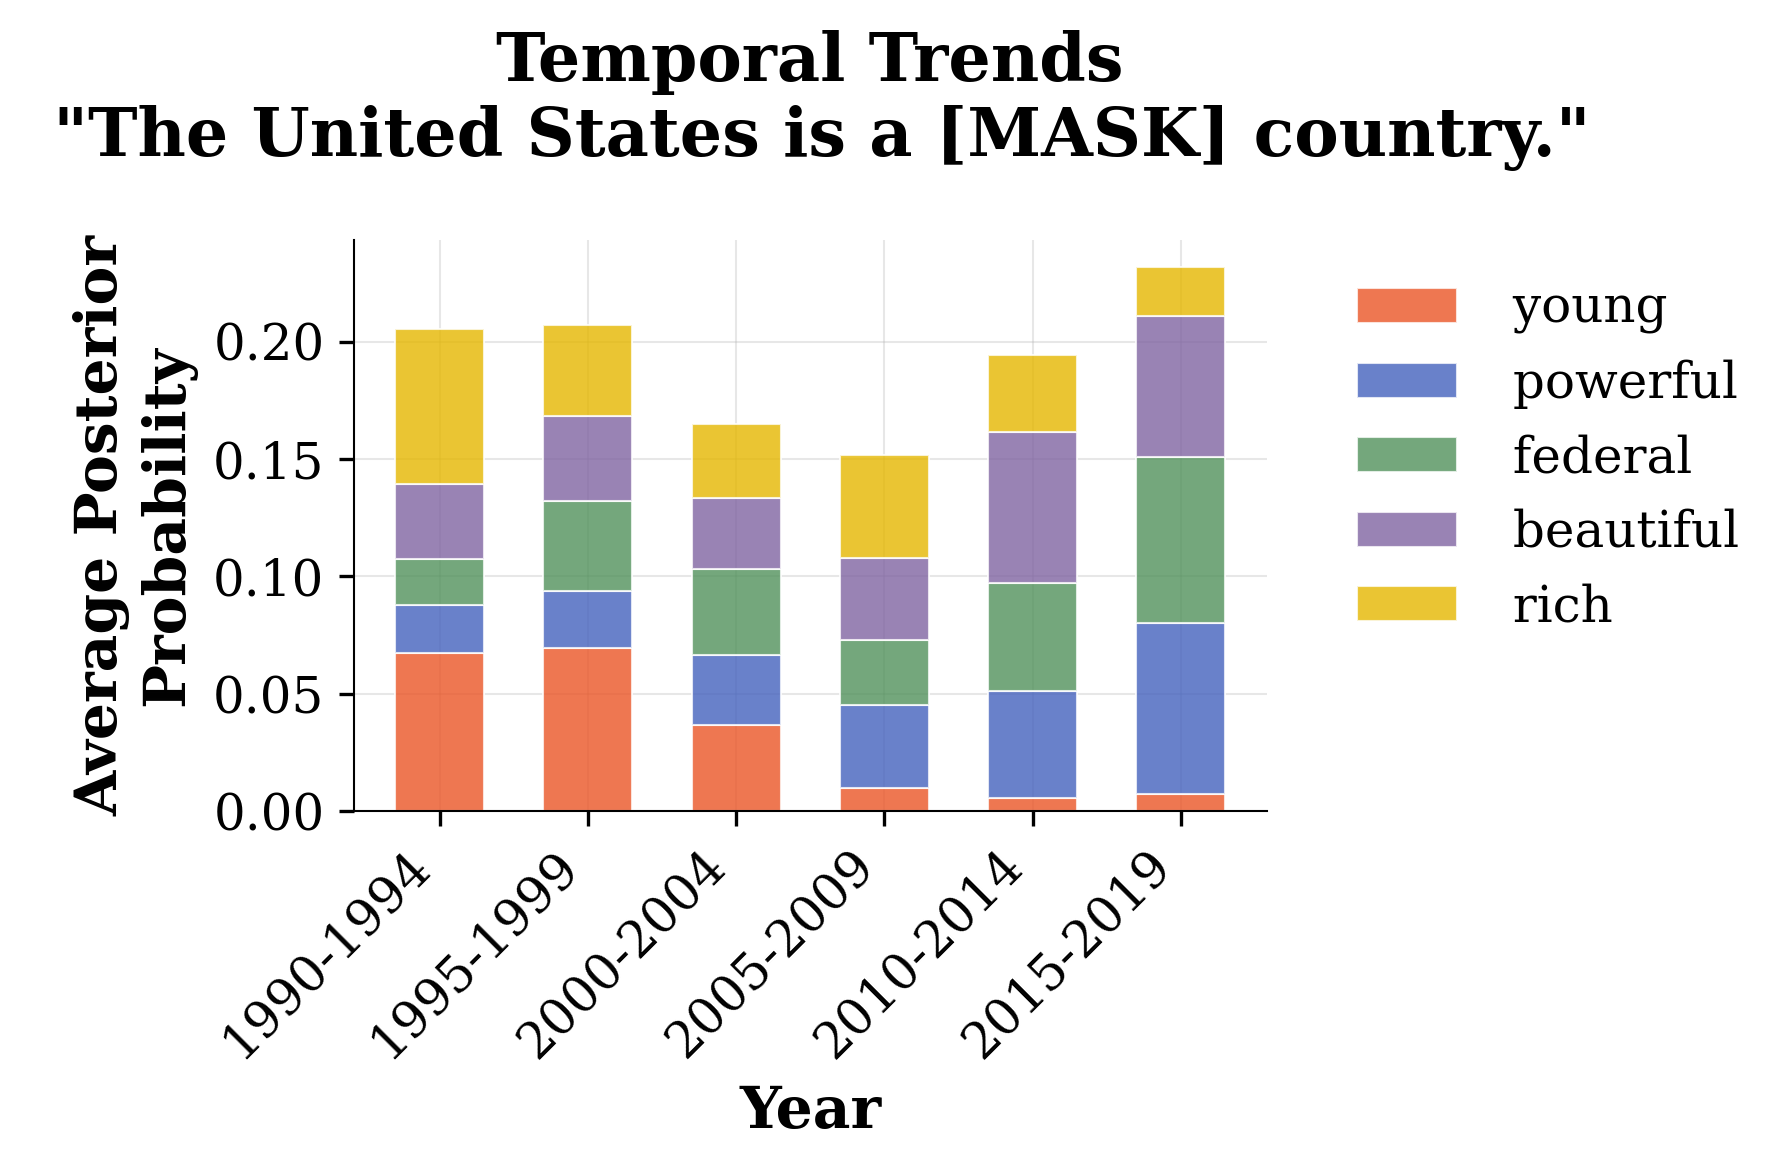

In [15]:
visualize_process_small('The United States is a [MASK] country.', top_k=25, saveas='us_country_small')


building posterior for nucleus:  [' optimistic', ' concerned', ' hopeful', ' uncertain', ' positive', ' confident', ' enthusiastic', ' excited', ' worried', ' anxious', ' cautious', ' unsure', ' knowledgeable', ' skeptical', ' curious', ' thinking', ' cynical', ' happy', ' optimism', ' nervous', ' negative', ' informed', ' good', ' comfortable', ' certain']


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Saved visualization to future_small.png


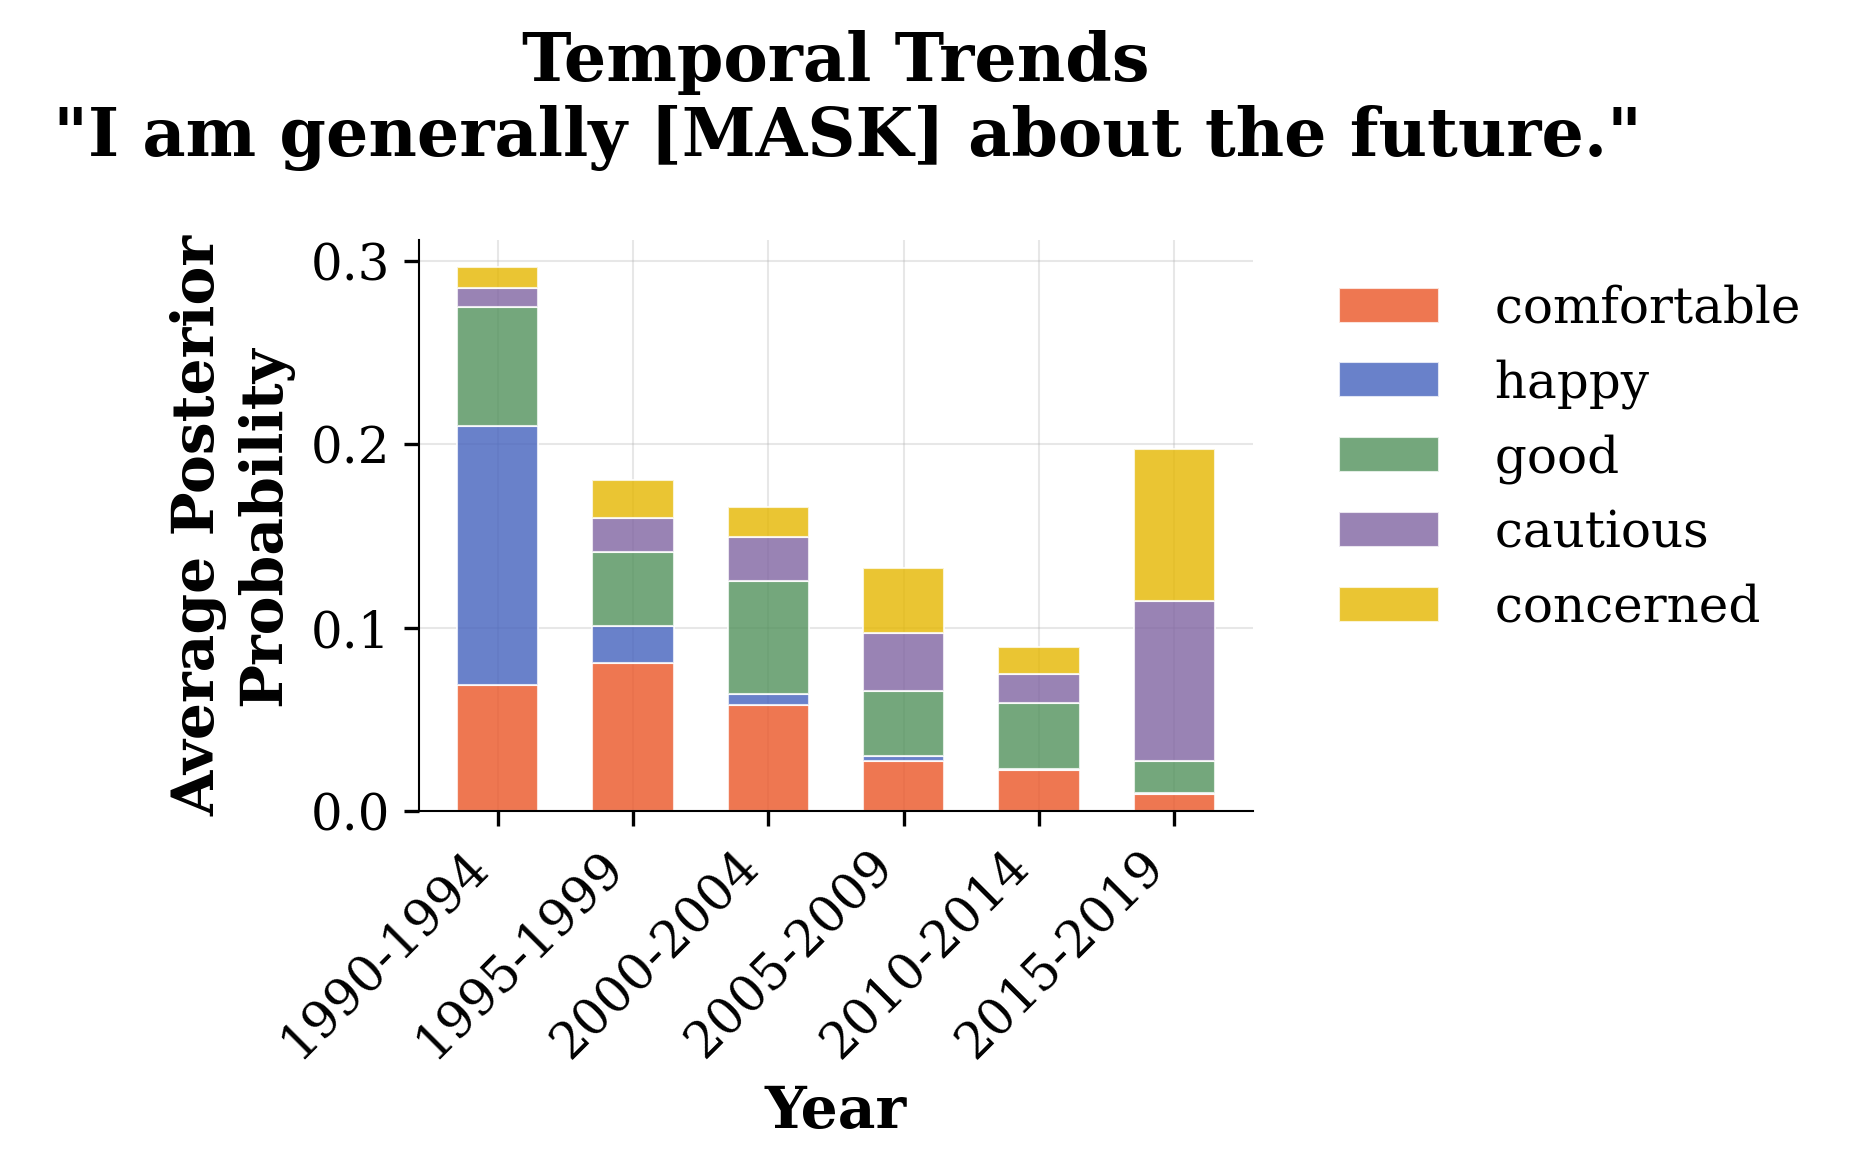

In [16]:
visualize_process_small('I am generally [MASK] about the future.', top_k=25, saveas='future_small')

In [7]:
visuzlize_process('I am generally [MASK] about the future.', top_k=25, saveas='future.html')

building posterior for nucleus:  [' optimistic', ' concerned', ' hopeful', ' uncertain', ' positive', ' confident', ' enthusiastic', ' excited', ' worried', ' anxious', ' cautious', ' unsure', ' knowledgeable', ' skeptical', ' curious', ' thinking', ' cynical', ' happy', ' optimism', ' nervous', ' negative', ' informed', ' good', ' comfortable', ' certain']


100%|██████████| 25/25 [00:04<00:00,  6.18it/s]
